<a href="https://colab.research.google.com/github/evanss2025/test/blob/main/Exploring_Slime_Mold_Inspired_Strategies_for_Improved_Domain_Adaptation_in_Visual_Recognition_with_Domain_Shift_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Exploring Slime Mold-Inspired Strategies for Improved Domain Adaptation in Visual Recognition with Domain Shift**

This code is a part of Sophia Evans's research project. The following creates a domain shift situation in which the MNIST dataset is used to train and validate a classification model, but then the model is tested on the SVHN dataset. This creates domain shift as although both are number datasets, the SVHN introduces new lighting and situations the MNIST trained model is not used to, limiting it's efficiency.

First, install tensorflow-datasets to gain access to the SVHN dataset

Import needed libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import numpy as np

Load the MNIST dataset from Keras. The MNIST dataset originally has 28x28px sized images, but the SVHN dataset has 32x32px images. Therefore, two make the two compatible, the MNIST dataset needs to be resized to 32x32px images.

In [ ]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(x_mnist, y_mnist), (_, _) = mnist.load_data()

# Resize MNIST images to 32x32 pixels
x_mnist_resized = tf.image.resize(x_mnist[..., tf.newaxis], (32, 32))
x_mnist_resized = tf.squeeze(x_mnist_resized)

After downloading the MNIST dataset, preprocess the data by converting it to a numpy array and clarify its class number and shape.

In [ ]:
# Preprocess MNIST data
x_mnist_resized = x_mnist_resized.numpy()
x_mnist_resized = x_mnist_resized.reshape((x_mnist_resized.shape[0], 32, 32, 1)).astype('float32') / 255
y_mnist = tf.keras.utils.to_categorical(y_mnist, num_classes=10)

Split the MNIST data into training and testing batches to be used later on.

In [ ]:
# Split data into train and test sets for both domains
source_train_data, source_test_data, y_mnist_train, y_mnist_test = train_test_split(
    x_mnist_resized, y_mnist, test_size=0.2, random_state=42
)

Now after downloading the MNIST dataset, do the same for the SVHN dataset. The dataset is downloaded from tensorflow's datasets and the appropriate feautres are extracted from it.

In [ ]:
!pip install tensorflow-datasets


In [ ]:
svhn_builder = tfds.builder('svhn_cropped')
svhn_builder.download_and_prepare()
svhn_dataset = svhn_builder.as_dataset()
svhn_dataset = tfds.as_numpy(svhn_dataset['train'])

# Extract features and labels from SVHN dataset
x_svhn = np.array([tf.image.rgb_to_grayscale(sample['image']).numpy().astype('float32') / 255 for sample in svhn_dataset])
y_svhn = np.array([sample['label'] for sample in svhn_dataset])

Split the data

In [ ]:
# Split data into train and test sets for the target domain
target_train_data, target_test_data, target_train_labels, target_test_labels = train_test_split(
    x_svhn, y_svhn, test_size=0.2, random_state=42
)

Double check that the datasets are compatible



In [ ]:
# Ensure target labels have the same shape as source labels
target_train_labels = tf.keras.utils.to_categorical(target_train_labels, num_classes=10)
target_test_labels = tf.keras.utils.to_categorical(target_test_labels, num_classes=10)

Use matplotlib to visualize an example from each dataset ensuring that they are both the same size and are compatible.

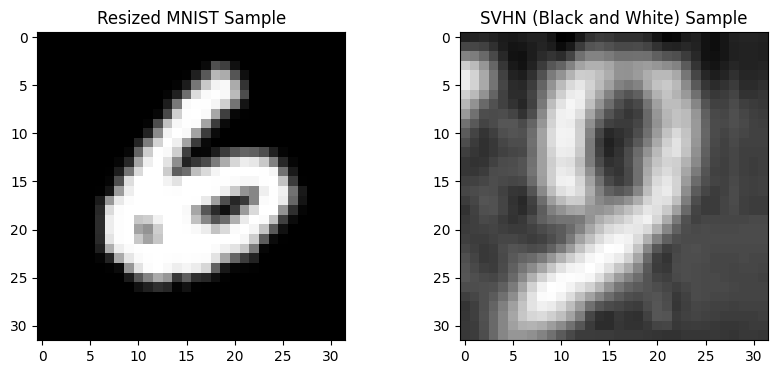

In [ ]:
# Visualize an example image from each dataset

plt.figure(figsize=(10, 4))

# MNIST
plt.subplot(1, 2, 1)
plt.imshow(source_train_data[56].reshape(32, 32), cmap='gray')
plt.title('Resized MNIST Sample')

# SVHN
plt.subplot(1, 2, 2)
plt.imshow(target_train_data[23].reshape(32, 32), cmap='gray')
plt.title('SVHN (Black and White) Sample')

plt.show()

Define model architecture for grayscale images


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))  # Update input shape
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Train on the source domain (MNIST)

In [ ]:
history = model.fit(source_train_data, y_mnist_train, epochs=2, validation_data=(source_test_data, y_mnist_test), batch_size=32)


Epoch 1/2
1500/1500 [==============================] - 49s 31ms/step - loss: 0.1732 - accuracy: 0.9486 - val_loss: 0.0922 - val_accuracy: 0.9724
Epoch 2/2
1500/1500 [==============================] - 54s 36ms/step - loss: 0.0622 - accuracy: 0.9804 - val_loss: 0.0619 - val_accuracy: 0.9830


Evaluate on the target domain (SVHN)


In [ ]:
target_predictions = model.predict(target_test_data)
target_accuracy = accuracy_score(np.argmax(target_test_labels, axis=1), np.argmax(target_predictions, axis=1))
target_f1_score = f1_score(np.argmax(target_test_labels, axis=1), np.argmax(target_predictions, axis=1), average='weighted')

print(f"Target Domain Accuracy: {target_accuracy}")
print(f"Target Domain F1 Score: {target_f1_score}")

458/458 [==============================] - 5s 10ms/step
Target Domain Accuracy: 0.18591318591318592
Target Domain F1 Score: 0.17307701685445193


Visualize the different measuring metrics to represent the efficiency of the model.

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

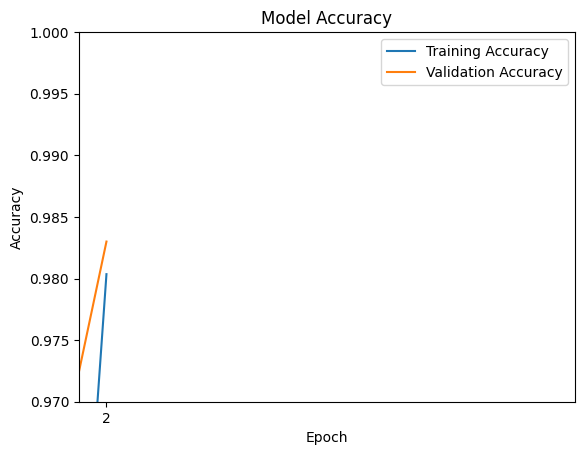

In [ ]:
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(epochs[1::2])
plt.xlim(1, 19)
plt.ylim(0.97, 1)
plt.legend()
plt.show()

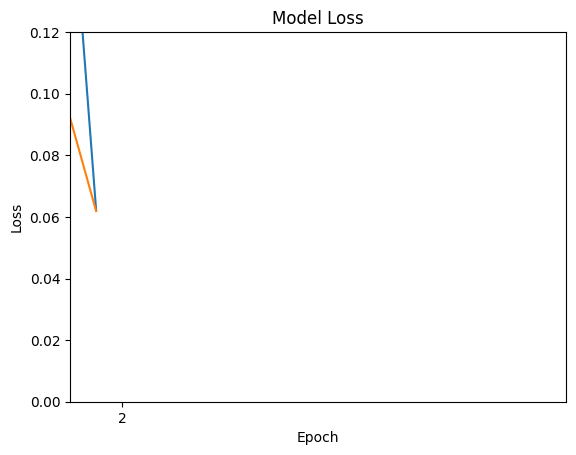

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(epochs[1::2])
plt.xlim(1, len(epochs))
plt.xlim(0, 19)
plt.ylim(0, 0.12)
plt.show()

Visualize the predictions on the source domain.

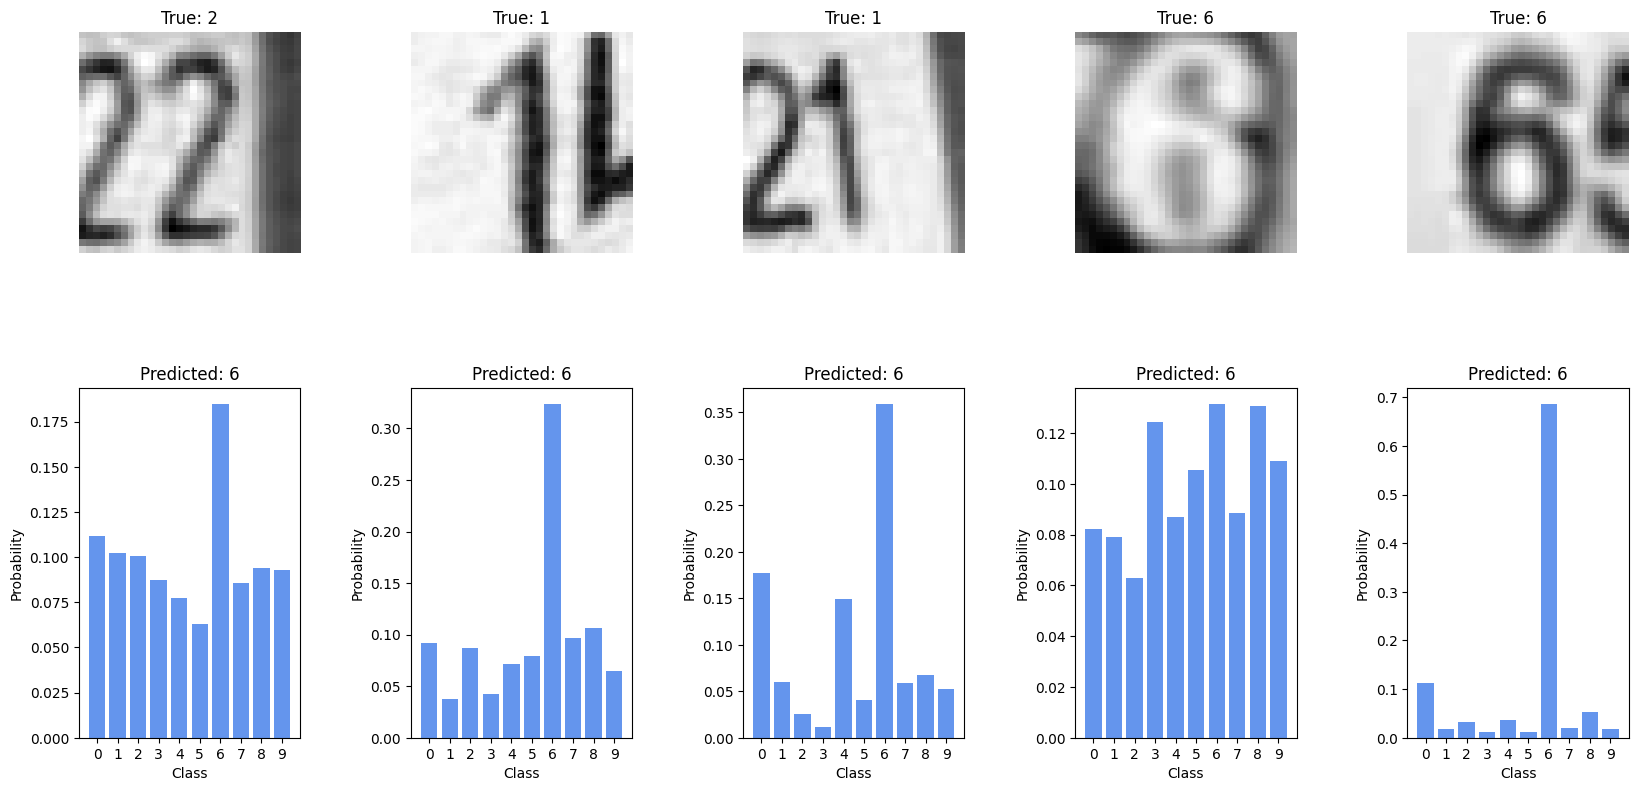

In [ ]:
%matplotlib inline


# Function to display a grid of images with predictions
def display_predictions(images, true_labels, predicted_labels, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(20, 10))
    plt.subplots_adjust(wspace=0.5)

    for i in range(num_images):
        axes[0, i].imshow(images[i].reshape(32, 32), cmap='gray')
        axes[0, i].set_title(f'True: {np.argmax(true_labels[i])}')
        axes[0, i].axis('off')

        bar_width = 0.8
        axes[1, i].bar(range(10), predicted_labels[i], color='cornflowerblue', width=bar_width)
        axes[1, i].set_title(f'Predicted: {np.argmax(predicted_labels[i])}')
        axes[1, i].set_xticks(range(10))
        axes[1, i].set_xticklabels(range(10))
        axes[1, i].set_xlabel('Class')
        axes[1, i].set_ylabel('Probability')

    plt.show()

# Display predictions for the first 5 images in the target domain
num_images_to_display = 5
display_predictions(target_test_data[1060:1065], target_test_labels[1060:1065], target_predictions[1060:1065])